# Exploratory Data Analysis: Natural Language Processing of Disaster Tweets (Is It Real or Unreal)

In [1]:
# Dependencies
import chardet
import cursive_re as cre
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re 
import string
import unicodedata


from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
from nltk.tree import Tree
from urllib.request import urlopen
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from unidecode import unidecode

In [2]:
# Check encoding because I am seeing some text that looks like it has been corrupted
# Read the first few thousand bytes to detect encoding
with open("Data/train.csv", "rb") as f:
    raw_data = f.read(100000)  # Read first 100KB
    result = chardet.detect(raw_data)
    detected_encoding = result['encoding']

print(f"Detected Encoding: {detected_encoding}")


Detected Encoding: utf-8


In [3]:
# Read in data and set the index column
file_path = "Data/train.csv"
df = pd.read_csv(file_path, encoding=detected_encoding, index_col=0)
df = df.reset_index(drop=True)
df

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
# Dictionary to store occurrences of corrupted characters
corrupted_counts = Counter()

# Function to detect and count non-ASCII (potentially corrupted) characters
def find_corrupted_chars(text):
    if isinstance(text, str):
        for char in re.findall(r"[^\x00-\x7F]", text):  # Find all non-ASCII characters
            corrupted_counts[char] += 1  # Increment count

# Loop through 'text' column and count occurrences of each corrupted character
df['text'].apply(find_corrupted_chars)

# Display the corrupted counts dictionary
print(corrupted_counts)

Counter({'\x89': 797, 'Û': 794, 'ª': 191, 'å': 96, 'Ï': 69, 'Ê': 66, '÷': 49, 'Ò': 45, '\x9d': 44, 'Ó': 33, 'Ì': 27, '¢': 10, '©': 10, '£': 6, '¨': 6, 'È': 5, '¼': 5, 'Ñ': 3, '¤': 3, '¡': 3, 'ã': 2, 'ü': 2, 'Ç': 2, '«': 2, '´': 1, 'â': 1, 'Â': 1, '¬': 1})


In [5]:
# Function to check if text contains non-ASCII characters
def contains_non_ascii(text):
    return bool(re.search(r'[^\x00-\x7F]', str(text)))  # Returns True if any non-ASCII character exists

# Filter rows that contain corrupted characters in any text column
df_corrupted = df[df.select_dtypes(include=['object']).applymap(contains_non_ascii).any(axis=1)]

df_corrupted


,keyword,location,text,target
38,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1
52,ablaze,Barbados,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0
53,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1
57,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0
71,accident,"St. Louis, MO",#stlouis #caraccidentlawyer Speeding Among Top...,0
...,...,...,...,...
7532,wreckage,iTunes,#science Now that a piece of wreckage from fli...,1
7549,wrecked,NaN,Cramer: IgerÛªs 3 words that wrecked DisneyÛ...,0
7584,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7586,NaN,NaN,#Sismo DETECTADO #JapÌ_n 15:41:07 Seismic inte...,1


In [6]:
df.loc[57].text

'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_ https://t.co/cYoMPZ1A0Z'

In [7]:
# Filter DataFrame to rows containing the corrupted sequence "ÛÒ"
filtered_df = df[df['text'].str.contains("ÛÒ", na=False)]
filtered_df

,keyword,location,text,target
38,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1
128,aftershock,304,'Remembering that you are going to die is the ...,0
133,aftershock,304,People who say it cannot be done should not in...,0
160,airplane%20accident,Thrissur,Horrible Accident Man Died In Wings Of ÛÏAirp...,1
342,armageddon,NaN,Paul Craig Roberts ÛÒ Vladimir Putin Issues M...,1
696,blazing,worldwide,Why Some Traffic Is Freezing Cold And Some Bla...,0
947,blown%20up,"Grimsby, England",My dogÛªs just blown his kennel up ÛÒ Bloody...,0
1480,catastrophe,"Denver, CO",#Denver CO #Insurance #Job: Claims Property Fi...,0
1528,chemical%20emergency,"Littleton, CO, USA",THE CHEMICAL BROTHERS to play The Armory in SF...,0
1534,chemical%20emergency,NaN,THE CHEMICAL BROTHERS to play The Armory in SF...,0


In [8]:
# Define the replacement dictionary
corrections = {
    "ÛÒ": "-",  # Em Dash
    "\x89ÛÓ": "-",  # Em Dash
    "@\x89Û_": "@_",  # Correcting @ mentions
    "\x89Û_": "_",  # General underscore correction
    "ã¢": "TM",  # Trademark symbol
    "\x89ÛÏ": '"',  # Left Double Quote
    "\x89Û\x9d": '"',  # Right Double Quote
    "\x89Ûª": "'", # Apostrophe
    "åÊ": " ",
    "\x89Û÷": "'",
    "å£": "£",
    # "å£": "GBP",    # British pounds
    # "£": "GBP",    # British pounds
    "# ": "#",     # remove spaces behind # signs
    # "€": "EUR",  # Euro
    # "$": "USD",  # US Dollar
    # "¥": "JPY",  # Japanese Yen
    # "₹": "INR",  # Indian Rupee
    # "₽": "RUB",  # Russian Ruble
    # "₩": "KRW",  # South Korean Won
    # "₱": "PHP",  # Philippine Peso
    # "₫": "VND",  # Vietnamese Dong
    # "₴": "UAH",  # Ukrainian Hryvnia
    # "₿": "BTC",  # Bitcoin
    "å¤}": "",   # Missing currency symbol
    "å_?": "",   # Missing currency symbol
    "åÇ": "...",  # Elipses
    "åÈ": ".",   # Period
    "ÌÑ1": "#1",   # Numeric ranking or ordinal indicator
    "ÌÑ": "x",   # Incorrect encoding of multiplication sign or resolution separator (800 × 582)
    "Ìü": "",   # Likely an extra misencoded character, should be removed
    "Ì´": "'",   # Misencoded apostrophe or accent mark
    "\n\n": " ", 
    "Ì©": "e",   # Misencoded accented character (Réunion)
    "Ì¼": "u",   # Misencoded "ü" in "música"
    "\x89Û¢": '"',   # Misencoded double quotes
    "å¡": "!",       # Misencoded exclamation mark
    "&amp;": " ",
    "å«": "'",   # Misencoded apostrophe (don’t → don't)
    "\x89âÂ": "",   # Corrupted text, likely from encoding errors—should be removed
    "å¨": "",   # Misencoded character, likely an extra artifact—should be removed
    "å¬": "",   # Misencoded character, likely an extra artifact—should be removed
    "Ì¤": "c",   # Misencoded "ç" (Suruç, a town in Turkey)
    "Ì_n": "an",   # Misencoded "ón" (Japón, Spanish for Japan)
    "Ì_": "i",     # Misencoded "í" (likely in words like "vídeo")
    "Nå¼": "number",   # Misencoded "Nº" (Number symbol, often in rankings)
    "å_": "",      # Extra misencoded artifact—should be removed
    "é": "e",
    "ón": "an",
    "ç": "c",
    'í': "i",
    "Ì¢": "",
    "\n": "",
    "å©": " @",
    "º": "o",
}
# Apply all replacements in Pandas
for bad, good in corrections.items():
    df['text'] = df['text'].str.replace(bad, good, regex=False)
    df['location'] = df['location'].str.replace(bad, good, regex=False)

In [9]:
# Filter DataFrame to show rows containing any of the corrupted sequences
pattern = "|".join(map(re.escape, corrections.keys()))
new_filtered_df = df[df['text'].str.contains(pattern, na=False, regex=True) | 
                     df['location'].str.contains(pattern, na=False, regex=True)]



In [10]:
# Dictionary to store occurrences of corrupted characters
corrupted_counts = Counter()

# Loop through 'text' column and count occurrences of each corrupted character
df['text'].apply(find_corrupted_chars)

# Display the corrupted counts dictionary
print(corrupted_counts)

Counter({'£': 6})


In [11]:
df_corrupted = df[df['text'].apply(contains_non_ascii)]

df_corrupted.text

956     #handbags Genuine Mulberry Antony Cross Body M...
1984    Unions say they are supportive of 'London' yet...
2389    Buyout Giants Bid To Derail £6bn Worldpay IPO ...
2558    Get £150 free bets when you register at Boyles...
6995    @ellenfromnowon 7-speed nexus shifter £9! (For...
7221    Incredulous at continued outcry of welfare bei...
Name: text, dtype: object

In [12]:
# Filter rows that contain corrupted characters in any text column
# df_corrupted = df[df.select_dtypes(include=['object']).applymap(contains_non_ascii).any(axis=1)]
# df_corrupted = df[df['text'].apply(contains_non_ascii)]

# df_corrupted

df['non_ascii_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if ord(c) > 127))
most_corrupted_row = df.loc[df['non_ascii_count'].idxmax()]

most_corrupted_row

keyword                                                   body%20bag
location                                                         NaN
text               #handbags Genuine Mulberry Antony Cross Body M...
target                                                             0
non_ascii_count                                                    1
Name: 956, dtype: object

In [13]:
# # # Filter DataFrame to rows containing the corrupted sequence "ÛÒ"
filtered_df = df[df['text'].str.contains('#', na=False)]
filtered_df.head(10)

,keyword,location,text,target,non_ascii_count
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0
5,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,0
6,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,0
11,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT ...,1,0
12,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1,0
13,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,1,0
14,NaN,NaN,Damage to school bus on 80 in multi car crash ...,1,0
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,0


In [14]:
df.loc[7480].text

'Ranking #artectura #pop2015 #number36 Florence + The Machine - Ship To Wreck https://t.co/9LE0B19lVF  #music #playlist #YouTube'

In [15]:
# #Inspect the corrupted data
# for idx,line in enumerate(df_corrupted['text']):
#     print(f"{idx}: {line}")

In [16]:
# Function to check for emojis in a string
def contains_emoji(text):
    emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F700-\U0001F77F"  # Alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric symbols
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)

    return bool(emoji_pattern.search(str(text)))

# Check if any column contains emojis
df_with_emoji = df[df.applymap(contains_emoji).any(axis=1)]
print(f"Rows containing emojis: {len(df_with_emoji)}")

# Show the first few rows with emojis
df_with_emoji.head()

Rows containing emojis: 0


,keyword,location,text,target,non_ascii_count


This is wrong. There are emojis in the data. I have at least seen ;) and :)

In [17]:
# Function to normalize text
def normalize_text(text):
    return unidecode(str(text))

# Create a list of dictionaries that include the index, corrupted text, and corrected text
df_corrupted_text_list = [
    {
        "index": value, 
        "corrupted_text": df.loc[value, 'text'], 
        "corrected_text": normalize_text(df.loc[value, 'text'])  # Apply repair while storing
    }
    for value in df_corrupted.index
]

# Apply normalization
df = df.applymap(lambda x: normalize_text(x) if isinstance(x, str) else x)

df.head()


,keyword,location,text,target,non_ascii_count
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0


In [18]:
# corrections_df = pd.DataFrame(df_corrupted_text_list)
# corrections_df.set_index("index", inplace=True)
# corrections_df

In [19]:
# # Filter rows that contain corrupted characters in any text column
# df_corrupted_2 = df[df.select_dtypes(include=['object']).applymap(contains_non_ascii).any(axis=1)]

# # Display only corrupted rows
# df_corrupted_2

In [20]:
# for idx, line in corrections_df.iterrows():
#     print(line['corrupted_text'])
#     print(line['corrected_text'])
#     print("="*20)

## Data Dictionary
- id:
    - index
- keyword:
    - is this generated or user defined?
- location:
    - where the tweeter is located, user defined - drop
- text:
    - content of the tweet
- target
    - 0: not disaster
    - 1: disaster

In [21]:
# Rows and columns
df.shape

(7613, 5)

In [22]:
# Number of null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   keyword          7552 non-null   object
 1   location         5080 non-null   object
 2   text             7613 non-null   object
 3   target           7613 non-null   int64 
 4   non_ascii_count  7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [23]:
# Target distribution
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

* 0: 57.03%
* 1: 42.97%

In [24]:
# Total missing values per feature
df.isnull().sum()

keyword              61
location           2533
text                  0
target                0
non_ascii_count       0
dtype: int64

In [25]:
# For every feature, how many unique values are present and how prevalent is each unique value
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")
    print(column)
    print("="*20)
    print(df[column].value_counts())
    print("="*20)

keyword: 221
keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64
location: 3339
location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Montreal, Quebec         1
Montreal                 1
IIT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3339, dtype: int64
text: 7503
text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...      10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #Prop

In [26]:
# Check for duplicated LINES in the code. This only lists the first one. 
df[df.duplicated()].head()

,keyword,location,text,target,non_ascii_count
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,0
119,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,0
164,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1,0
630,bioterrorism,NaN,To fight bioterrorism sir.,1,0


In [27]:
# Using loc to view the text at one specific(for no particular reason other than to remember how loc works) index. 
df.loc[5144].text

'Finnish ministers: Fennovoima nuclear reactor will go ahead http://t.co/vB3VFm76ke #worldnews #news #breakingnews'

In [28]:
# Closer look at one of the duplicates
df[df["text"] == "11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh..."]

,keyword,location,text,target,non_ascii_count
3578,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3589,fatal,Varanasi,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3591,fatal,Thane,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3597,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3600,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3603,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3604,fatal,Bangalore,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3610,fatal,Dimapur,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3613,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1,0
3614,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1,0


In [29]:
# Location is supplied but the user and isn't necessarily truthful. Since it can't be verified, we are going to try dropping it. 
no_location_df = df.drop("location", axis=1)
no_location_df

,keyword,text,target,non_ascii_count
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,NaN,All residents asked to 'shelter in place' are ...,1,0
3,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0
...,...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse int...,1,0
7609,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0
7610,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0
7611,NaN,Police investigating after an e-bike collided ...,1,0


In [30]:
# After the location column is removed, what do our null values look like. 
no_location_df.isnull().sum()

keyword            61
text                0
target              0
non_ascii_count     0
dtype: int64

In [31]:
# Keyword can't be confirmed whether or not it is generated by an automated system or by a user but either way, our current opinion is that it is not useful for model.
just_text_df = no_location_df.drop("keyword", axis=1)
just_text_df.head()

,text,target,non_ascii_count
0,Our Deeds are the Reason of this #earthquake M...,1,0
1,Forest fire near La Ronge Sask. Canada,1,0
2,All residents asked to 'shelter in place' are ...,1,0
3,"13,000 people receive #wildfires evacuation or...",1,0
4,Just got sent this photo from Ruby #Alaska as ...,1,0


In [32]:
just_text_df_copy = just_text_df.copy()

In [33]:
# Drop all but the first of duplicate sets 
just_text_df_copy_duplicates = just_text_df_copy.drop_duplicates()
print(just_text_df_copy_duplicates.shape)
print(just_text_df_copy_duplicates.target.value_counts())
just_text_df_copy.head()

(7521, 3)
0    4315
1    3206
Name: target, dtype: int64


,text,target,non_ascii_count
0,Our Deeds are the Reason of this #earthquake M...,1,0
1,Forest fire near La Ronge Sask. Canada,1,0
2,All residents asked to 'shelter in place' are ...,1,0
3,"13,000 people receive #wildfires evacuation or...",1,0
4,Just got sent this photo from Ruby #Alaska as ...,1,0


### Target balance
* 0: 57.37%
* 1: 42.63%

In [34]:
# Drop all duplicate sets, don't even keep the first or last.
just_text_df_duplicated = just_text_df[~just_text_df.duplicated()]
print(just_text_df_duplicated.shape)
print(just_text_df_duplicated.target.value_counts())
just_text_df_duplicated.head()

(7521, 3)
0    4315
1    3206
Name: target, dtype: int64


,text,target,non_ascii_count
0,Our Deeds are the Reason of this #earthquake M...,1,0
1,Forest fire near La Ronge Sask. Canada,1,0
2,All residents asked to 'shelter in place' are ...,1,0
3,"13,000 people receive #wildfires evacuation or...",1,0
4,Just got sent this photo from Ruby #Alaska as ...,1,0


### Target Balance
* 0: 56.04%
* 1: 42.63%

In [35]:
df_to_tokenize = just_text_df_duplicated.copy()

# **Tokenization**

In [36]:
# Tokenizing the text
tokenized = []
for idx in just_text_df.index:
    sentence = just_text_df.loc[idx]["text"]
    tokenized.append(sentence.split())
just_text_df["tokens"] = tokenized
just_text_df.head()

,text,target,non_ascii_count,tokens
0,Our Deeds are the Reason of this #earthquake M...,1,0,"[Our, Deeds, are, the, Reason, of, this, #eart..."
1,Forest fire near La Ronge Sask. Canada,1,0,"[Forest, fire, near, La, Ronge, Sask., Canada]"
2,All residents asked to 'shelter in place' are ...,1,0,"[All, residents, asked, to, 'shelter, in, plac..."
3,"13,000 people receive #wildfires evacuation or...",1,0,"[13,000, people, receive, #wildfires, evacuati..."
4,Just got sent this photo from Ruby #Alaska as ...,1,0,"[Just, got, sent, this, photo, from, Ruby, #Al..."


- We are going to need to look at the overall statement in some manner. 
- Maybe we can look at the frequent words in the yeses versus the nos and then come up with a way to first run through an algorithm to verify if the statement is definitely NOT about a disaster and then move it to a second stage that calculates a probability that the statement is definitely a disaster?
- So:
    - 1. EDA on the individiual words, which words associate the most with yes or no?
    - 2. Same on the sentences?
- What about special characters? 
    - Do more no's use emojis than yes's
    - Do yes's use more : or ; ?
    - Is there a difference in grammar between yes's and no's?
    - What about the # and @? Do these have any bearing on a yes or no?
- make everything lowercase during processing?
- if a word is in all upper case is it more likely to be a 1?

- Another thought is how does the grammar distribution work on the target? nouns, verbs, determiners, etc -- maybe look at pg 103 and sent_tokenize, word_tokenize, and pos_tag

## I think we should have tokenized the df that didn't have duplicates but I wish to do this in several ways.

In [37]:
df_split_words_no_changes = df_to_tokenize.copy()


In [38]:
# Tokenizing the text
tokenized = []
for idx in df_split_words_no_changes.index:
    words = df_split_words_no_changes.loc[idx]["text"]
    tokenized.append(words.split())
df_split_words_no_changes["tokens"] = tokenized
df_split_words_no_changes.head()

,text,target,non_ascii_count,tokens
0,Our Deeds are the Reason of this #earthquake M...,1,0,"[Our, Deeds, are, the, Reason, of, this, #eart..."
1,Forest fire near La Ronge Sask. Canada,1,0,"[Forest, fire, near, La, Ronge, Sask., Canada]"
2,All residents asked to 'shelter in place' are ...,1,0,"[All, residents, asked, to, 'shelter, in, plac..."
3,"13,000 people receive #wildfires evacuation or...",1,0,"[13,000, people, receive, #wildfires, evacuati..."
4,Just got sent this photo from Ruby #Alaska as ...,1,0,"[Just, got, sent, this, photo, from, Ruby, #Al..."


In [39]:
# page 100 of the text
word_tokenize_df = df_to_tokenize.copy()
# Tokenizing the text
tokenized = []
for idx in word_tokenize_df.index:
    words = word_tokenize_df.loc[idx]["text"]
    tokenized.append(nltk.word_tokenize(words))
word_tokenize_df["tokens"] = tokenized
word_tokenize_df.head()


,text,target,non_ascii_count,tokens
0,Our Deeds are the Reason of this #earthquake M...,1,0,"[Our, Deeds, are, the, Reason, of, this, #, ea..."
1,Forest fire near La Ronge Sask. Canada,1,0,"[Forest, fire, near, La, Ronge, Sask, ., Canada]"
2,All residents asked to 'shelter in place' are ...,1,0,"[All, residents, asked, to, 'shelter, in, plac..."
3,"13,000 people receive #wildfires evacuation or...",1,0,"[13,000, people, receive, #, wildfires, evacua..."
4,Just got sent this photo from Ruby #Alaska as ...,1,0,"[Just, got, sent, this, photo, from, Ruby, #, ..."


In [40]:
# Checking to see if the 2 different ways of tokenizing made a difference
print(df_split_words_no_changes.equals(word_tokenize_df))

False


In [41]:
# Ok, what is different?
print(df_split_words_no_changes.compare(word_tokenize_df))
# word_tokenize separates the special symbols like # and @ from the words behind them

                                                 tokens  \
                                                   self   
0     [Our, Deeds, are, the, Reason, of, this, #eart...   
1        [Forest, fire, near, La, Ronge, Sask., Canada]   
2     [All, residents, asked, to, 'shelter, in, plac...   
3     [13,000, people, receive, #wildfires, evacuati...   
4     [Just, got, sent, this, photo, from, Ruby, #Al...   
...                                                 ...   
7604  [#WorldNews, Fallen, powerlines, on, G:link, t...   
7605  [on, the, flip, side, I'm, at, Walmart, and, t...   
7606  [Suicide, bomber, kills, 15, in, Saudi, securi...   
7608  [Two, giant, cranes, holding, a, bridge, colla...   
7612  [The, Latest:, More, Homes, Razed, by, Norther...   

                                                         
                                                  other  
0     [Our, Deeds, are, the, Reason, of, this, #, ea...  
1      [Forest, fire, near, La, Ronge, Sask, ., Canada]  


In [42]:
tweets_df = df_to_tokenize.copy()

In [43]:
tweets_df = tweets_df[["text", "target"]]

In [44]:
tweets_df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


In [45]:
from nltk.tokenize import regexp_tokenize
pattern = r'''(?x) # A verbose pattern
[\$£]?\d+[\.:%]?\d*%?
|(?:[A-Z]\.)+
|(?:https?://)?(?:\w+\.)(?:\w{2,})+(?:[\w/]+)?
|[@\#]?\w+(?:[-']\w+)*
|\.\.\.
|[!?]+
|:[()]
'''

tweets_df['tokens'] = tweets_df['text'].apply(lambda tweet: regexp_tokenize(tweet, pattern))
tweets_df.head(40)

,text,target,tokens
0,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #eart..."
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, shelter, in, place..."
3,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, #wildfires, evacuat..."
4,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #Al..."
5,#RockyFire Update => California Hwy. 20 closed...,1,"[#RockyFire, Update, California, Hwy, 20, clos..."
6,#flood #disaster Heavy rain causes flash flood...,1,"[#flood, #disaster, Heavy, rain, causes, flash..."
7,I'm on top of the hill and I can see a fire in...,1,"[I'm, on, top, of, the, hill, and, I, can, see..."
8,There's an emergency evacuation happening now ...,1,"[There's, an, emergency, evacuation, happening..."
9,I'm afraid that the tornado is coming to our a...,1,"[I'm, afraid, that, the, tornado, is, coming, ..."


In [46]:
tweets_df.loc[37]

text      INEC Office in Abia Set Ablaze - http://t.co/3...
target                                                    1
tokens    [INEC, Office, in, Abia, Set, Ablaze, http://t...
Name: 37, dtype: object

In [47]:
tweets_df['line'] = tweets_df.text.apply(TweetTokenizer().tokenize)

tweets_df

,text,target,tokens,line
0,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #eart...","[Our, Deeds, are, the, Reason, of, this, #eart..."
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, ., Canada]"
2,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, ', shelter, in, pl..."
3,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, #wildfires, evacuat...","[13,000, people, receive, #wildfires, evacuati..."
4,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #Al...","[Just, got, sent, this, photo, from, Ruby, #Al..."
...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,"[#WorldNews, Fallen, powerlines, on, G, link, ...","[#WorldNews, Fallen, powerlines, on, G, :, lin..."
7605,on the flip side I'm at Walmart and there is a...,1,"[on, the, flip, side, I'm, at, Walmart, and, t...","[on, the, flip, side, I'm, at, Walmart, and, t..."
7606,Suicide bomber kills 15 in Saudi security site...,1,"[Suicide, bomber, kills, 15, in, Saudi, securi...","[Suicide, bomber, kills, 15, in, Saudi, securi..."
7608,Two giant cranes holding a bridge collapse int...,1,"[Two, giant, cranes, holding, a, bridge, colla...","[Two, giant, cranes, holding, a, bridge, colla..."


In [48]:
tweets_df['tokens'].compare(tweets_df['line'])

,self,other
1,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, ., Canada]"
2,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, ', shelter, in, pl..."
3,"[13, 000, people, receive, #wildfires, evacuat...","[13,000, people, receive, #wildfires, evacuati..."
5,"[#RockyFire, Update, California, Hwy, 20, clos...","[#RockyFire, Update, =, >, California, Hwy, .,..."
6,"[#flood, #disaster, Heavy, rain, causes, flash...","[#flood, #disaster, Heavy, rain, causes, flash..."
...,...,...
7599,"[1.3, #Earthquake, in, 9, Km, Ssw, Of, Anza, C...","[1.3, #Earthquake, in, 9Km, Ssw, Of, Anza, Cal..."
7602,"[a, siren, just, went, off, and, it, wasn't, t...","[a, siren, just, went, off, and, it, wasn't, t..."
7604,"[#WorldNews, Fallen, powerlines, on, G, link, ...","[#WorldNews, Fallen, powerlines, on, G, :, lin..."
7606,"[Suicide, bomber, kills, 15, in, Saudi, securi...","[Suicide, bomber, kills, 15, in, Saudi, securi..."


In [49]:
tweets_df[["text", "line", "target"]]

,text,line,target
0,Our Deeds are the Reason of this #earthquake M...,"[Our, Deeds, are, the, Reason, of, this, #eart...",1
1,Forest fire near La Ronge Sask. Canada,"[Forest, fire, near, La, Ronge, Sask, ., Canada]",1
2,All residents asked to 'shelter in place' are ...,"[All, residents, asked, to, ', shelter, in, pl...",1
3,"13,000 people receive #wildfires evacuation or...","[13,000, people, receive, #wildfires, evacuati...",1
4,Just got sent this photo from Ruby #Alaska as ...,"[Just, got, sent, this, photo, from, Ruby, #Al...",1
...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,"[#WorldNews, Fallen, powerlines, on, G, :, lin...",1
7605,on the flip side I'm at Walmart and there is a...,"[on, the, flip, side, I'm, at, Walmart, and, t...",1
7606,Suicide bomber kills 15 in Saudi security site...,"[Suicide, bomber, kills, 15, in, Saudi, securi...",1
7608,Two giant cranes holding a bridge collapse int...,"[Two, giant, cranes, holding, a, bridge, colla...",1


In [50]:
tweets_df.loc[28]

text         Cooool :)
target               0
tokens    [Cooool, :)]
line      [Cooool, :)]
Name: 28, dtype: object

In [51]:
from collections import Counter

# Initialize counters for tweets with target 1 and target 0
counter_1 = Counter()
counter_0 = Counter()

# Loop over the tokens in the 'line' column and the corresponding target values
for tokens, target in zip(tweets_df['line'], tweets_df['target']):
    for token in tokens:
        # Check if the token begins with '#'
        if token.startswith('#'):
            if target == 1:
                counter_1[token] += 1
            elif target == 0:
                counter_0[token] += 1

print("Hashtag counts for target 1:", counter_1)
print("Hashtag counts for target 0:", counter_0)


Hashtag counts for target 1: Counter({'#': 60, '#News': 29, '#news': 23, '#Hiroshima': 21, '#Japan': 14, '#hot': 13, '#prebreak': 13, '#best': 13, '#India': 10, '#yyc': 10, '#Sismo': 9, '#abstorm': 8, '#earthquake': 7, '#Earthquake': 7, '#WX': 7, '#disaster': 6, '#world': 6, '#MH370': 6, '#okwx': 6, '#hailstorm': 6, '#Africa': 6, '#Fukushima': 6, '#wildfires': 5, '#wildfire': 5, '#Rohingya': 5, '#drought': 5, '#Libya': 5, '#science': 5, '#socialnews': 5, '#RockyFire': 4, '#BREAKING': 4, '#California': 4, '#Manchester': 4, '#US': 4, '#Phoenix': 4, '#Myanmar': 4, '#Sittwe': 4, '#EarthQuake': 4, '#WorldNews': 4, '#terrorism': 4, '#GBBO': 4, '#Nuclear': 4, '#ISIS': 4, '#IDFire': 4, '#flood': 3, '#flooding': 3, '#Accident': 3, '#NewYork': 3, '#bioterrorism': 3, '#IranDeal': 3, '#breaking': 3, '#USA': 3, '#tech': 3, '#preparedness': 3, '#Business': 3, '#UK': 3, '#weather': 3, '#tcot': 3, '#floods': 3, '#Zionist': 3, '#Terrorist': 3, '#Buffalo': 3, '#mumbai': 3, '#wmata': 3, '#ModiMinistry': 

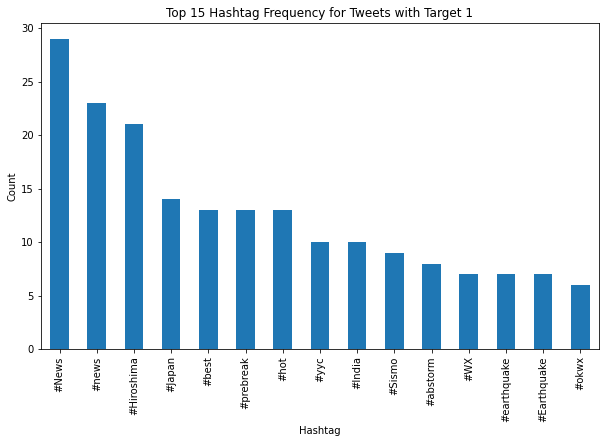

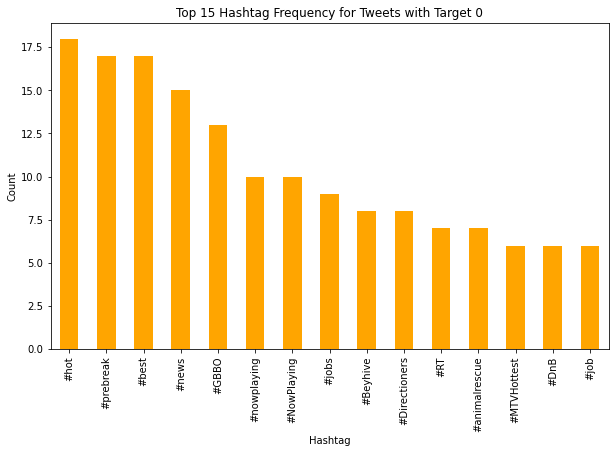

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Counters to pandas Series
hashtags_target1 = pd.Series(counter_1)
hashtags_target0 = pd.Series(counter_0)

# Exclude the lone '#' token if it exists
hashtags_target1 = hashtags_target1.drop('#', errors='ignore')
hashtags_target0 = hashtags_target0.drop('#', errors='ignore')

# Sort the series and limit to the top 15 hashtags
top_hashtags_target1 = hashtags_target1.sort_values(ascending=False).head(15)
top_hashtags_target0 = hashtags_target0.sort_values(ascending=False).head(15)

# Plot for tweets with target 1
plt.figure(figsize=(10, 6))
top_hashtags_target1.plot(kind='bar')
plt.title('Top 15 Hashtag Frequency for Tweets with Target 1')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()

# Plot for tweets with target 0
plt.figure(figsize=(10, 6))
top_hashtags_target0.plot(kind='bar', color='orange')
plt.title('Top 15 Hashtag Frequency for Tweets with Target 0')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()


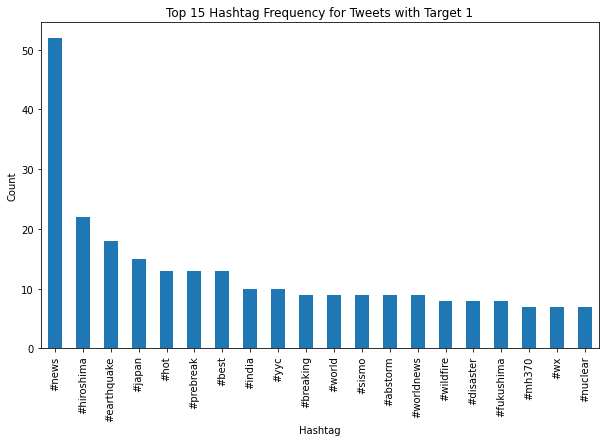

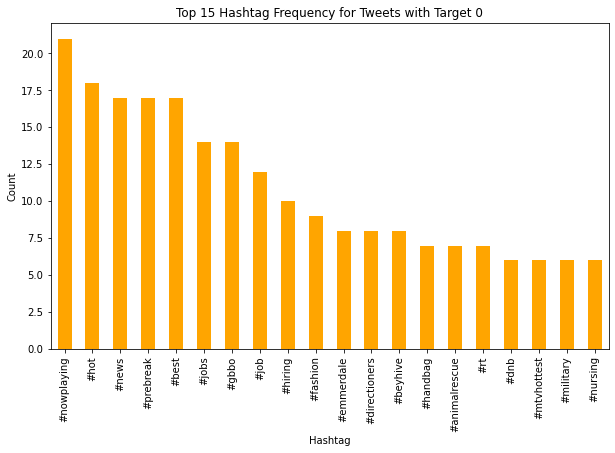

In [53]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Initialize counters for tweets with target 1 and target 0
counter_1 = Counter()
counter_0 = Counter()

# Loop over the 'line' column and the corresponding 'target' values
for tokens, target in zip(tweets_df['line'], tweets_df['target']):
    for token in tokens:
        # Process tokens that start with '#' but are not just a lone '#'
        if token.startswith('#') and token != '#':
            # Convert to lowercase to combine case variants (e.g., "#Python" and "#python")
            normalized_token = token.lower()
            if target == 1:
                counter_1[normalized_token] += 1
            elif target == 0:
                counter_0[normalized_token] += 1

# Convert the counters to pandas Series for plotting
hashtags_target1 = pd.Series(counter_1)
hashtags_target0 = pd.Series(counter_0)

# Sort each Series by count and select the top 15 hashtags
top_hashtags_target1 = hashtags_target1.sort_values(ascending=False).head(20)
top_hashtags_target0 = hashtags_target0.sort_values(ascending=False).head(20)

# Plot for tweets with target 1
plt.figure(figsize=(10, 6))
top_hashtags_target1.plot(kind='bar')
plt.title('Top 15 Hashtag Frequency for Tweets with Target 1')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()

# Plot for tweets with target 0
plt.figure(figsize=(10, 6))
top_hashtags_target0.plot(kind='bar', color='orange')
plt.title('Top 15 Hashtag Frequency for Tweets with Target 0')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()


                target_1  target_0  total
#news                 52        17     69
#hot                  13        18     31
#best                 13        17     30
#prebreak             13        17     30
#nowplaying            2        21     23
#gbbo                  4        14     18
#hiring                1        10     11
#world                 9         2     11
#sismo                 9         1     10
#emmerdale             1         8      9
#nuclear               7         2      9
#rt                    2         7      9
#islam                 4         5      9
#irandeal              4         5      9
#directioners          1         8      9
#tcot                  4         4      8
#handbag               1         7      8
#nursing               2         6      8
#mtvhottest            1         6      7
#business              3         4      7
#us                    4         3      7
#seattle               2         5      7
#course                2         4

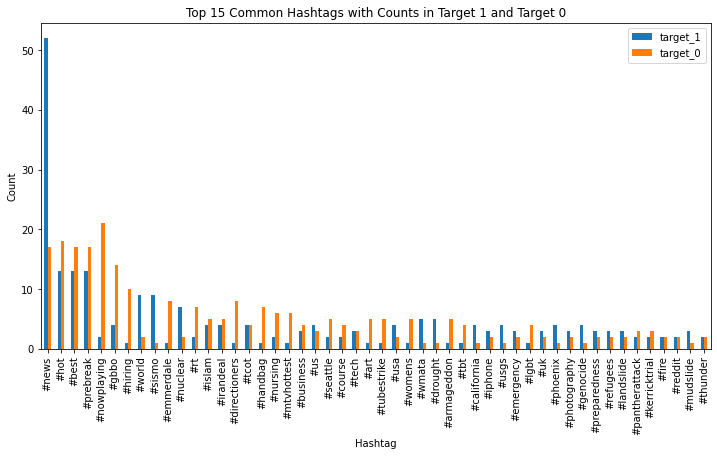

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the Counters to pandas Series (assuming counter_1 and counter_0 are defined)
hashtags_target1 = pd.Series(counter_1)
hashtags_target0 = pd.Series(counter_0)

# Find hashtags common to both target groups
common_hashtags = hashtags_target1.index.intersection(hashtags_target0.index)

# Create a DataFrame with counts from both targets for these common hashtags
common_df = pd.DataFrame({
    'target_1': hashtags_target1.loc[common_hashtags],
    'target_0': hashtags_target0.loc[common_hashtags]
})

# Optionally, sort by the total count (sum of both targets) and select the top 15
common_df['total'] = common_df['target_1'] + common_df['target_0']
common_df = common_df.sort_values(by='total', ascending=False).head(50)

# Display the DataFrame
print(common_df)

# Plot the results as a grouped bar chart
common_df[['target_1', 'target_0']].plot(kind='bar', figsize=(12, 6))
plt.title('Top 15 Common Hashtags with Counts in Target 1 and Target 0')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()


In [55]:
# Check if "#nowplaying" is in the target 1 hashtags and print its count
if '#nowplaying' in hashtags_target1.index:
    print(f"#nowplaying appears in target 1 with a count of {hashtags_target1['#nowplaying']}")
else:
    print("#nowplaying does not appear in target 1.")


#nowplaying appears in target 1 with a count of 2


Correlation Matrix:
          target_1  target_0
target_1  1.000000  0.450024
target_0  0.450024  1.000000


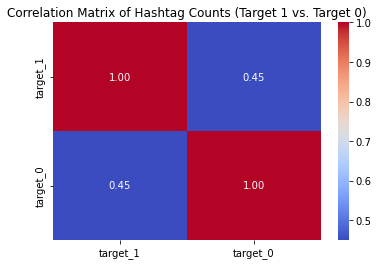

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for the counts in target 1 and target 0
corr_matrix = common_df[['target_1', 'target_0']].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Optionally, plot the correlation matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Hashtag Counts (Target 1 vs. Target 0)")
plt.show()


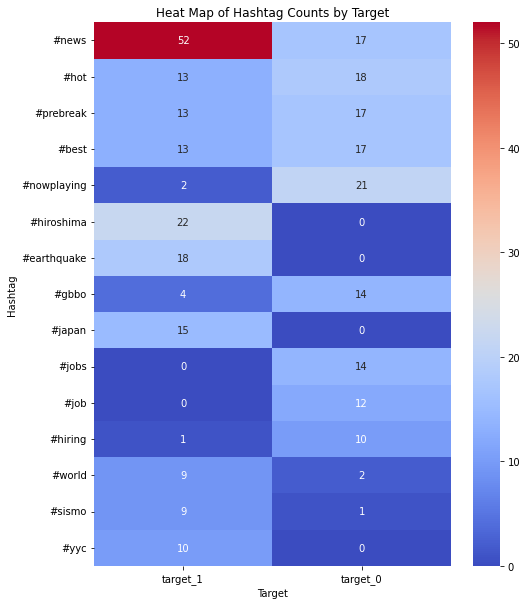

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame from the two counters.
# Any missing counts (if a hashtag appears only in one target) are filled with 0.
df_counts = pd.DataFrame({
    'target_1': pd.Series(counter_1),
    'target_0': pd.Series(counter_0)
}).fillna(0)

# Create a total count column to sort the hashtags by overall frequency.
df_counts['total'] = df_counts['target_1'] + df_counts['target_0']

# Sort by total count and select the top 15 hashtags.
df_top15 = df_counts.sort_values('total', ascending=False).head(15)

# For the heat map, we only need the target columns.
heat_data = df_top15[['target_1', 'target_0']]

# Plot the heat map using seaborn.
plt.figure(figsize=(8, 10))
sns.heatmap(heat_data, annot=True, cmap='coolwarm', fmt='.0f')
plt.title('Heat Map of Hashtag Counts by Target')
plt.xlabel('Target')
plt.ylabel('Hashtag')
plt.show()


<Figure size 720x432 with 0 Axes>

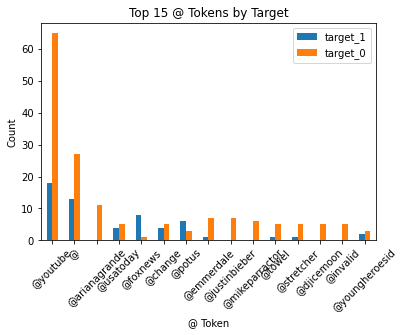

<Figure size 720x432 with 0 Axes>

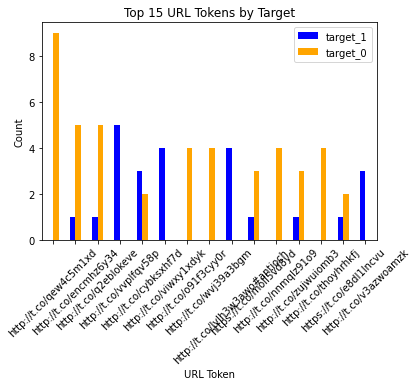

In [58]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Initialize counters for @ tokens and URL tokens for each target group
counter_at_1 = Counter()
counter_at_0 = Counter()
counter_url_1 = Counter()
counter_url_0 = Counter()

# Loop over the tokens in the 'line' column and the corresponding target values
for tokens, target in zip(tweets_df['line'], tweets_df['target']):
    for token in tokens:
        # Process @ tokens (mentions)
        if token.startswith('@'):
            normalized_token = token.lower()  # combine different cases
            if target == 1:
                counter_at_1[normalized_token] += 1
            elif target == 0:
                counter_at_0[normalized_token] += 1
        
        # Process URL tokens
        # Here we assume a URL starts with 'http://' or 'https://' or 'www.'
        if re.match(r'^(https?://|www\.)', token):
            normalized_token = token.lower()
            if target == 1:
                counter_url_1[normalized_token] += 1
            elif target == 0:
                counter_url_0[normalized_token] += 1

# Create a DataFrame for @ tokens.
df_at = pd.DataFrame({
    'target_1': pd.Series(counter_at_1),
    'target_0': pd.Series(counter_at_0)
}).fillna(0)
df_at['total'] = df_at['target_1'] + df_at['target_0']
df_at_top15 = df_at.sort_values('total', ascending=False).head(15)

# Plot the @ tokens as a grouped bar chart
plt.figure(figsize=(10, 6))
df_at_top15[['target_1', 'target_0']].plot(kind='bar')
plt.title('Top 15 @ Tokens by Target')
plt.xlabel('@ Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Create a DataFrame for URL tokens.
df_url = pd.DataFrame({
    'target_1': pd.Series(counter_url_1),
    'target_0': pd.Series(counter_url_0)
}).fillna(0)
df_url['total'] = df_url['target_1'] + df_url['target_0']
df_url_top15 = df_url.sort_values('total', ascending=False).head(15)

# Plot the URL tokens as a grouped bar chart
plt.figure(figsize=(10, 6))
df_url_top15[['target_1', 'target_0']].plot(kind='bar', color=['blue', 'orange'])
plt.title('Top 15 URL Tokens by Target')
plt.xlabel('URL Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


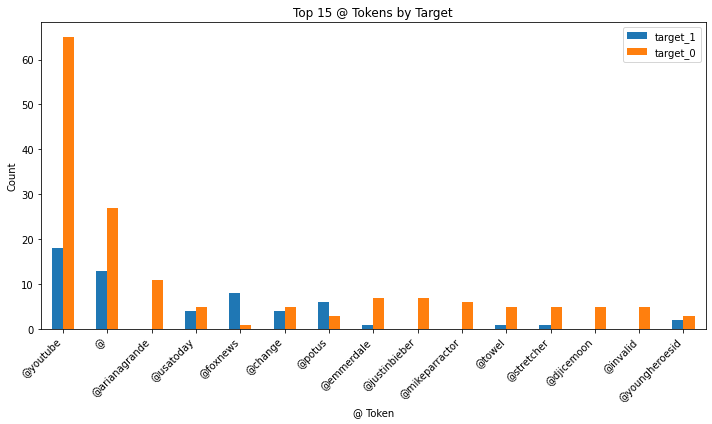

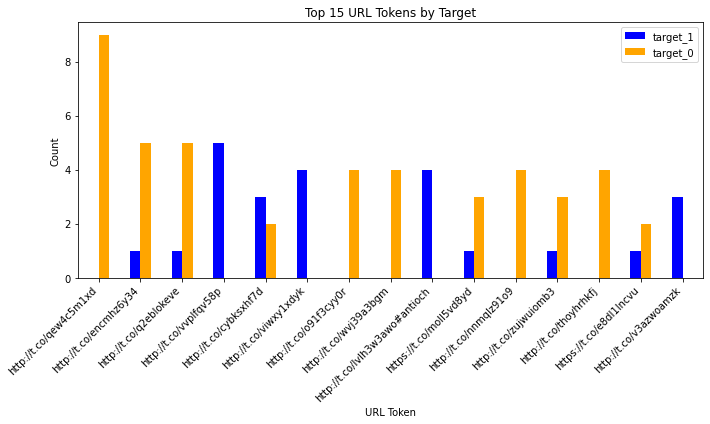

In [59]:
import matplotlib.pyplot as plt

# For @ tokens:
ax = df_at_top15[['target_1', 'target_0']].plot(kind='bar', figsize=(10, 6))
ax.set_xticks(range(len(df_at_top15.index)))  # Ensure ticks for each row
ax.set_xticklabels(df_at_top15.index, rotation=45, ha='right')
plt.title('Top 15 @ Tokens by Target')
plt.xlabel('@ Token')
plt.ylabel('Count')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# For URL tokens:
ax = df_url_top15[['target_1', 'target_0']].plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
ax.set_xticks(range(len(df_url_top15.index)))
ax.set_xticklabels(df_url_top15.index, rotation=45, ha='right')
plt.title('Top 15 URL Tokens by Target')
plt.xlabel('URL Token')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [60]:
def mentions_hashtags_urls(tw):
    mnt =re.compile("@\w+(?:[-']\w+)*|")
    hash =re.compile("#\w+(?:[-]\w+)*")
    urls =re.compile("http\S+")
    mention ="".join(mnt.findall(tw))
    hashtag ="".join(hash.findall(tw))
    link ="".join(urls.findall(tw))

    return mention, hashtag, link

In [61]:
tweets_df['Mentions'], tweets_df['Hashtags'],\
tweets_df['URLs'] =zip(*tweets_df['text'].\
map(mentions_hashtags_urls))

In [62]:
tweets_df

,text,target,tokens,line,Mentions,Hashtags,URLs
0,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #eart...","[Our, Deeds, are, the, Reason, of, this, #eart...",,#earthquake,
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, ., Canada]",,,
2,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, ', shelter, in, pl...",,,
3,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, #wildfires, evacuat...","[13,000, people, receive, #wildfires, evacuati...",,#wildfires,
4,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #Al...","[Just, got, sent, this, photo, from, Ruby, #Al...",,#Alaska#wildfires,
...,...,...,...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,"[#WorldNews, Fallen, powerlines, on, G, link, ...","[#WorldNews, Fallen, powerlines, on, G, :, lin...",,#WorldNews,http://t.co/EYSVvzA7Qm
7605,on the flip side I'm at Walmart and there is a...,1,"[on, the, flip, side, I'm, at, Walmart, and, t...","[on, the, flip, side, I'm, at, Walmart, and, t...",,,
7606,Suicide bomber kills 15 in Saudi security site...,1,"[Suicide, bomber, kills, 15, in, Saudi, securi...","[Suicide, bomber, kills, 15, in, Saudi, securi...",,,http://t.co/nF4IculOje
7608,Two giant cranes holding a bridge collapse int...,1,"[Two, giant, cranes, holding, a, bridge, colla...","[Two, giant, cranes, holding, a, bridge, colla...",,,http://t.co/STfMbbZFB5


In [63]:
tweets_df.Mentions.value_counts()

                                       5525
@YouTube                                 60
@Change                                   9
@POTUS                                    6
@ViralSpell                               5
                                       ... 
@greateranglia                            1
@OhYayyyYay                               1
@GerryConnolly@RepDonBeyer@timkaine       1
@ItsQueenBaby                             1
@engineshed                               1
Name: Mentions, Length: 1798, dtype: int64

In [118]:
extra_stopwords = [
    "get", "he", "that", "didnt", "doesnt", "dont", "isnt", "ive", "know",
    "least", "let", "like","may", "much", "must", "never", "one", "other", "rt",
    "said", "see", "seem", "she", "take", "thank", "there", "though", "still",
    "us", "use", "want", "wasnt", "way", "well", "what", "without", "wont",
    "would", "yet", "your"
]

stop_words = stopwords.words('english')
stop_words.extend(["i've"])
stop_words.extend(["your"])
stop_words.extend(["im"])
stop_words.extend(extra_stopwords)
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [119]:
porter = nltk.PorterStemmer()
porter

def tw_preprocess(tw):
    tw = tw.lower()
    tw = re.sub("@\w+(?:[-']\w+)*", "",tw)
    tw = re.sub(r"\S*\d\S*", "",tw)
    tw = re.sub("http\S+","",tw)
    tw = re.sub("[#|']","",tw)
    tokens = TweetTokenizer().tokenize(tw)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [porter.stem(t) for t in tokens]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = " ".join(tokens)
    return tokens

In [120]:
tweets_df["Processed_Tweet"] = tweets_df["text"].apply(tw_preprocess)

In [121]:
tweets_df

,text,target,tokens,line,Mentions,Hashtags,URLs,Processed_Tweet
0,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #eart...","[Our, Deeds, are, the, Reason, of, this, #eart...",,#earthquake,,deed reason earthquak allah forgiv
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, ., Canada]",,,,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, ', shelter, in, pl...",,,,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, #wildfires, evacuat...","[13,000, people, receive, #wildfires, evacuati...",,#wildfires,,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #Al...","[Just, got, sent, this, photo, from, Ruby, #Al...",,#Alaska#wildfires,,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,"[#WorldNews, Fallen, powerlines, on, G, link, ...","[#WorldNews, Fallen, powerlines, on, G, :, lin...",,#WorldNews,http://t.co/EYSVvzA7Qm,worldnew fallen powerlin g link tram updat fir...
7605,on the flip side I'm at Walmart and there is a...,1,"[on, the, flip, side, I'm, at, Walmart, and, t...","[on, the, flip, side, I'm, at, Walmart, and, t...",,,,flip side walmart bomb everyon evacu stay tune...
7606,Suicide bomber kills 15 in Saudi security site...,1,"[Suicide, bomber, kills, 15, in, Saudi, securi...","[Suicide, bomber, kills, 15, in, Saudi, securi...",,,http://t.co/nF4IculOje,suicid bomber kill saudi secur site mosqu reut...
7608,Two giant cranes holding a bridge collapse int...,1,"[Two, giant, cranes, holding, a, bridge, colla...","[Two, giant, cranes, holding, a, bridge, colla...",,,http://t.co/STfMbbZFB5,two giant crane hold bridg collaps nearbi home


In [122]:
no_features = 1000
vectoriser = CountVectorizer(min_df=2, max_features=no_features)
vectoriser

CountVectorizer(max_features=1000, min_df=2)

In [123]:
tw_vectorised = vectoriser.fit_transform(tweets_df['Processed_Tweet'])
tw_vectorised_names = vectoriser.get_feature_names()
tw_vectorised_names[:5]

c:\Users\Sharon\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aba', 'abandon', 'abc', 'ablaz', 'absolut']

In [124]:
tw_vectorised_names

['aba',
 'abandon',
 'abc',
 'ablaz',
 'absolut',
 'accid',
 'account',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'affect',
 'aftershock',
 'ago',
 'agre',
 'ahead',
 'aint',
 'air',
 'aircraft',
 'airplan',
 'airport',
 'alabama',
 'alarm',
 'album',
 'allow',
 'almost',
 'alon',
 'alreadi',
 'also',
 'alway',
 'ambul',
 'america',
 'american',
 'amid',
 'ancient',
 'angel',
 'angri',
 'anim',
 'annihil',
 'anniversari',
 'anoth',
 'answer',
 'anthrax',
 'anyon',
 'anyth',
 'apocalyps',
 'apollo',
 'appear',
 'area',
 'arent',
 'arm',
 'armageddon',
 'armi',
 'around',
 'arrest',
 'arriv',
 'arson',
 'arsonist',
 'art',
 'articl',
 'ash',
 'ask',
 'ass',
 'atom',
 'attack',
 'aug',
 'august',
 'australia',
 'avalanch',
 'avoid',
 'away',
 'awesom',
 'babi',
 'back',
 'bad',
 'bag',
 'ball',
 'ban',
 'bang',
 'bar',
 'base',
 'battl',
 'bayelsa',
 'bc',
 'beach',
 'beat',
 'beauti',
 'becom',
 'bed',
 'begin',
 'behind',
 'believ',
 'best',
 'better',
 'big',
 'bigger'

In [125]:
tweets_df

,text,target,tokens,line,Mentions,Hashtags,URLs,Processed_Tweet
0,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #eart...","[Our, Deeds, are, the, Reason, of, this, #eart...",,#earthquake,,deed reason earthquak allah forgiv
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, ., Canada]",,,,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, ', shelter, in, pl...",,,,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, #wildfires, evacuat...","[13,000, people, receive, #wildfires, evacuati...",,#wildfires,,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #Al...","[Just, got, sent, this, photo, from, Ruby, #Al...",,#Alaska#wildfires,,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,"[#WorldNews, Fallen, powerlines, on, G, link, ...","[#WorldNews, Fallen, powerlines, on, G, :, lin...",,#WorldNews,http://t.co/EYSVvzA7Qm,worldnew fallen powerlin g link tram updat fir...
7605,on the flip side I'm at Walmart and there is a...,1,"[on, the, flip, side, I'm, at, Walmart, and, t...","[on, the, flip, side, I'm, at, Walmart, and, t...",,,,flip side walmart bomb everyon evacu stay tune...
7606,Suicide bomber kills 15 in Saudi security site...,1,"[Suicide, bomber, kills, 15, in, Saudi, securi...","[Suicide, bomber, kills, 15, in, Saudi, securi...",,,http://t.co/nF4IculOje,suicid bomber kill saudi secur site mosqu reut...
7608,Two giant cranes holding a bridge collapse int...,1,"[Two, giant, cranes, holding, a, bridge, colla...","[Two, giant, cranes, holding, a, bridge, colla...",,,http://t.co/STfMbbZFB5,two giant crane hold bridg collaps nearbi home


c:\Users\Sharon\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


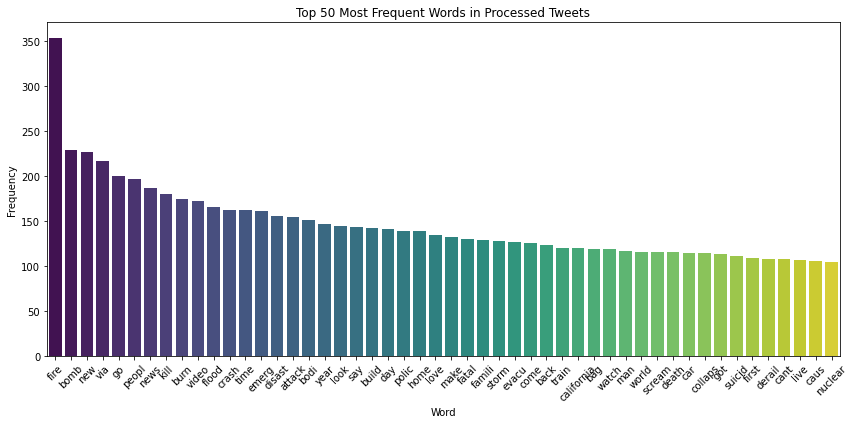

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sum the word counts across all tweets (each column represents a word)
# .A1 converts the sparse matrix sum to a 1-D numpy array
word_counts = np.array(tw_vectorised.sum(axis=0)).flatten()

# Get the feature names (the vectorized words)
words = vectoriser.get_feature_names()

# Create a DataFrame with words and their counts
df_word_counts = pd.DataFrame({'word': words, 'count': word_counts})

# Sort the DataFrame by count in descending order
df_word_counts = df_word_counts.sort_values(by='count', ascending=False)

# Visualize the top 20 most frequent words
top_n = 50
plt.figure(figsize=(12, 6))
sns.barplot(data=df_word_counts.head(top_n), x='word', y='count', palette="viridis")
plt.title(f"Top {top_n} Most Frequent Words in Processed Tweets")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


c:\Users\Sharon\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 1728x576 with 0 Axes>

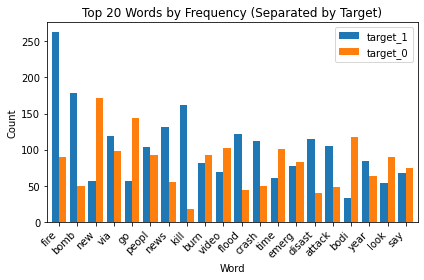

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create boolean masks for target 1 and target 0 tweets
mask_1 = tweets_df['target'] == 1
mask_0 = tweets_df['target'] == 0

# Sum the word counts over tweets for each target group.
# The result is a 1 x n_words sparse matrix; convert it to a 1D numpy array.
word_counts_target1 = np.array(tw_vectorised[mask_1].sum(axis=0)).flatten()
word_counts_target0 = np.array(tw_vectorised[mask_0].sum(axis=0)).flatten()

# Get the feature names (words) from the vectoriser.
words = vectoriser.get_feature_names()

# Build a DataFrame with counts per word for each target.
df_word_counts = pd.DataFrame({
    'word': words,
    'target_1': word_counts_target1,
    'target_0': word_counts_target0
})

# Optionally, compute the total frequency across both targets and sort by it.
df_word_counts['total'] = df_word_counts['target_1'] + df_word_counts['target_0']
df_word_counts = df_word_counts.sort_values(by='total', ascending=False)

# Let's say we want to visualize the top 20 words.
top_n = 20
df_top = df_word_counts.head(top_n)

# Set the word column as the index for plotting.
df_top = df_top.set_index('word')

# Create a grouped bar chart comparing counts for target 1 and target 0.
plt.figure(figsize=(24, 8))
ax = df_top[['target_1', 'target_0']].plot(kind='bar', width=0.8)
ax.set_title("Top 20 Words by Frequency (Separated by Target)")
ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.set_xticklabels(df_top.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [131]:
df_word_counts

,word,target_1,target_0,total
334,fire,263,90,353
120,bomb,179,50,229
599,new,56,171,227
936,via,119,98,217
376,go,56,144,200
...,...,...,...,...
306,experi,5,9,14
558,mention,7,7,14
0,aba,5,9,14
838,stress,2,11,13


## LDA

In [133]:
n_compoments = range(3,8)
search_params = {"n_components": n_compoments, 
                 "learning_decay": [0.6, 0.8, 1.0]}

In [134]:
lda = LatentDirichletAllocation(
    max_iter=10,
    learning_method="online", 
    random_state=0,
    evaluate_every=-1,
    learning_offset=50.0
)

In [135]:
model = GridSearchCV(lda, 
                     param_grid=search_params,
                     cv=15)

In [136]:
model.fit(tw_vectorised)
best_lda_model = model.best_estimator_

In [137]:
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 1.0, 'n_components': 3}


In [138]:
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(tw_vectorised))

Best Log Likelihood Score:  -23086.641925750864
Model Perplexity:  884.6488768295184


In [139]:
lda_output=best_lda_model.transform(tw_vectorised)
lda_output

array([[0.77744331, 0.11125735, 0.11129935],
       [0.31280624, 0.61673674, 0.07045702],
       [0.04847185, 0.90879518, 0.04273297],
       ...,
       [0.16867675, 0.02651929, 0.80480396],
       [0.04138975, 0.04293907, 0.91567118],
       [0.16831758, 0.79137835, 0.04030407]])

In [140]:
topicnames = ['Topic ' + str(i) for i in range(best_lda_model.n_components)]
topicnames

['Topic 0', 'Topic 1', 'Topic 2']

In [141]:
df_document_topic = pd.DataFrame(
    np.round(lda_output, 2),
    columns=topicnames
)

In [145]:
df_document_topic

,Topic 0,Topic 1,Topic 2
0,0.78,0.11,0.11
1,0.31,0.62,0.07
2,0.05,0.91,0.04
3,0.07,0.88,0.06
4,0.06,0.22,0.72
...,...,...,...
7516,0.05,0.90,0.05
7517,0.31,0.63,0.06
7518,0.17,0.03,0.80
7519,0.04,0.04,0.92


In [ ]:
tweets_df = pd.concat([tweets_df, df_document_topic], axis=1)


In [143]:
tweets_df

,text,target,tokens,line,Mentions,Hashtags,URLs,Processed_Tweet,Topic 0,Topic 1,Topic 2
0,Our Deeds are the Reason of this #earthquake M...,1.0,"[Our, Deeds, are, the, Reason, of, this, #eart...","[Our, Deeds, are, the, Reason, of, this, #eart...",,#earthquake,,deed reason earthquak allah forgiv,0.78,0.11,0.11
1,Forest fire near La Ronge Sask. Canada,1.0,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, ., Canada]",,,,forest fire near la rong sask canada,0.31,0.62,0.07
2,All residents asked to 'shelter in place' are ...,1.0,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, ', shelter, in, pl...",,,,resid ask shelter place notifi offic evacu she...,0.05,0.91,0.04
3,"13,000 people receive #wildfires evacuation or...",1.0,"[13, 000, people, receive, #wildfires, evacuat...","[13,000, people, receive, #wildfires, evacuati...",,#wildfires,,peopl receiv wildfir evacu order california,0.07,0.88,0.06
4,Just got sent this photo from Ruby #Alaska as ...,1.0,"[Just, got, sent, this, photo, from, Ruby, #Al...","[Just, got, sent, this, photo, from, Ruby, #Al...",,#Alaska#wildfires,,got sent photo rubi alaska smoke wildfir pour ...,0.06,0.22,0.72
...,...,...,...,...,...,...,...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1.0,"[#WorldNews, Fallen, powerlines, on, G, link, ...","[#WorldNews, Fallen, powerlines, on, G, :, lin...",,#WorldNews,http://t.co/EYSVvzA7Qm,worldnew fallen powerlin g link tram updat fir...,NaN,NaN,NaN
7605,on the flip side I'm at Walmart and there is a...,1.0,"[on, the, flip, side, I'm, at, Walmart, and, t...","[on, the, flip, side, I'm, at, Walmart, and, t...",,,,flip side walmart bomb everyon evacu stay tune...,NaN,NaN,NaN
7606,Suicide bomber kills 15 in Saudi security site...,1.0,"[Suicide, bomber, kills, 15, in, Saudi, securi...","[Suicide, bomber, kills, 15, in, Saudi, securi...",,,http://t.co/nF4IculOje,suicid bomber kill saudi secur site mosqu reut...,NaN,NaN,NaN
7608,Two giant cranes holding a bridge collapse int...,1.0,"[Two, giant, cranes, holding, a, bridge, colla...","[Two, giant, cranes, holding, a, bridge, colla...",,,http://t.co/STfMbbZFB5,two giant crane hold bridg collaps nearbi home,NaN,NaN,NaN


In [146]:
dominant_topic = np.argmax(df_document_topic[topicnames].values, axis=1)
tweets_df["Dominant_Topic"] = dominant_topic
tweets_df

ValueError: Length of values (7521) does not match length of index (7606)

In [ ]:
tweets_df[['text','Dominant_Topic']].head(4)

In [ ]:
df_topic_distribution =(
    tweets_df['Dominant_Topic'].value_counts().reset_index(
        name="Num Documents"))
df_topic_distribution.columns =['TopicNum',
'Num Documents']

In [ ]:
def topic_words(model, feature_names, n_words=10):
    for idx, topic in enumerate(model.components_):
        print('Topic'.format(idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[: -n_words -1:-1]]))

In [ ]:
topic_words(best_lda_model, tw_vectorised_names, n_words=5)

In [ ]:
testtweets = "Data/test.csv"
testtweets = pd.read_csv(testtweets, encoding="utf-8")
testtweets.head()

In [ ]:
testtweets['Processed_Tweet'] = testtweets['Tweet'].apply(tw_preprocess)
testtweets.head()

In [ ]:
def determine_topic(x, vec,model):
    mytext =[x]
    vec_transf =vec.transform(mytext)
    topic_prob_scores =model.transform(vec_transf)
    topic =np.argmax(topic_prob_scores)
    return topic

In [ ]:
testtweets['Topic']=testtweets['Processed_Tweet'].apply(determine_topic, vec=vectoriser, model=best_lda_model)

In [ ]:
testtweets[['Tweet','Topic']].tail(3)